In [18]:
# Importing packages needed
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import Tap
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib Widget
from astropy.table import join
import time

In [29]:
def cross_reference_gaia_starhorse(object_name, radius_deg):
    simbad_result_table = Simbad.query_object(object_name)

    if simbad_result_table is not None and 'RA' in simbad_result_table.colnames and 'DEC' in simbad_result_table.colnames:
        simbad_ra = simbad_result_table['RA'][0]
        simbad_dec = simbad_result_table['DEC'][0]

        simbad_coord = coord.SkyCoord(simbad_ra, simbad_dec, unit=(u.deg, u.deg), frame="icrs")

        # Define your query
        gaia_query = f"""
        SELECT 
            SOURCE_ID, ra, dec, parallax, pmra, pmdec,
            phot_g_mean_flux, phot_g_mean_flux_error, phot_g_mean_mag,
            phot_bp_mean_flux, phot_bp_mean_flux_error, phot_bp_mean_mag,
            phot_rp_mean_flux, phot_rp_mean_flux_error, phot_rp_mean_mag,
            bp_rp, bp_g, g_rp, l, b
        FROM
            gaiadr3.gaia_source
        WHERE
            CONTAINS(POINT('ICRS', gaiadr3.gaia_source.ra, gaiadr3.gaia_source.dec), 
            CIRCLE('ICRS', {simbad_coord.ra.deg}, {simbad_coord.dec.deg}, {radius_deg})) = 1
        """
        gaia_job = Gaia.launch_job_async(gaia_query)
        gaia_result = gaia_job.get_results()
        if len(gaia_result) > 0:
            # Perform the crossmatch using TAP (Table Access Protocol)
            tap_service_url = "http://tapvizier.u-strasbg.fr/TAPVizieR/tap/"
            tap_service = Tap(url=tap_service_url)
            # Selecting Starhorse catalog
            query = f"SELECT * FROM \"I/354/starhorse2021\" WHERE CONTAINS(POINT('ICRS', \"RA_ICRS\", \"DE_ICRS\"), CIRCLE('ICRS', {simbad_coord.ra.deg}, {simbad_coord.dec.deg}, {radius_deg})) = 1"
            max_retries = 3
            retry_delay = 10  # seconds
            for attempt in range(1, max_retries + 1):
                try:
                    starhorse_job = tap_service.launch_job_async(query)
                    starhorse_result = starhorse_job.get_results()
                    break  # Break out of the loop if successful
                except TimeoutError as e:
                    print(f"TimeoutError: {e}. Retrying after {retry_delay} seconds...")
                    time.sleep(retry_delay)
            else:
                raise RuntimeError(f"Failed after {max_retries} attempts. Aborting.")
        
            return gaia_result, starhorse_result
        else:
            print("No Gaia sources found in the specified radius.")
            return None, None
    else:
        print(f"Simbad query for object {object_name} returned no results. Returning None.")
        return None, None

def save_to_csv(results, filename):
    if results is not None:
        #df = results.to_pandas()
        results.to_csv(filename, index=False)
    else:
        print("Results are empty. Not saving to CSV.")

def main():
    # Change this to your object name for the Simbad query
    object_name = input("What cluster would like to use for classification?")

    # Change this to your radius for the cone search (in degrees)
    radius_deg = input("What radius would you like to use?")

    # Perform cross-referencing with cone search
    gaia_result, starhorse_result = cross_reference_gaia_starhorse(object_name, radius_deg)

    # Check if results are not empty
    if gaia_result is not None and starhorse_result is not None:

        # Print column names for debugging
        print("Gaia Columns:", gaia_result.colnames)
        print("StarHorse Columns:", starhorse_result.colnames)

        # Merge based on column names
        starhorse_result.rename_column('Source', 'SOURCE_ID')
        merged_results = join(gaia_result, starhorse_result, keys='SOURCE_ID', join_type='inner')
        
        # Add magnitude errors to Gaia data
        merged_results['phot_g_mean_mag_error']  = (2.5 / np.log(10)) * (merged_results['phot_g_mean_flux_error'] / merged_results['phot_g_mean_flux'])
        merged_results['phot_bp_mean_mag_error'] = (2.5 / np.log(10)) * (merged_results['phot_bp_mean_flux_error'] / merged_results['phot_bp_mean_flux'])
        merged_results['phot_rp_mean_mag_error'] = (2.5 / np.log(10)) * (merged_results['phot_rp_mean_flux_error'] / merged_results['phot_rp_mean_flux'])

        # Save the merged results to a single CSV file
        merged_results = merged_results.to_pandas()
        #n_merged_results = merged_results.drop(['solution_id'], axis=1)
        save_to_csv(merged_results, 'Data/merged.csv')

        # Display the merged results
        print("Merged Results:")
        print(merged_results)

    else:
        print("No results to merge.")

if __name__ == "__main__":
    main()

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Gaia Columns: ['SOURCE_ID', 'ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'l', 'b']
StarHorse Columns: ['Source', 'RA_ICRS', 'DE_ICRS', 'mass16', 'mass50', 'mass84', 'teff16', 'teff50', 'teff84', 'logg16', 'logg50', 'logg84', 'met16', 'met50', 'met84', 'dist05', 'dist16', 'dist50', 'dist84', 'dist95', 'AV05', 'AV16', 'AV50', 'AV84', 'AV95', 'fidelity', 'XGal', 'YGal', 'ZGal', 'RGal', 'FlagPhoto', 'FlagOut', 'BP_RPCorr', 'AG50', 'ABP50', 'ARP50', 'GMAG0', 'BP-RP0']
Merged Results:
                SOURCE_ID        ra        dec  parallax       pmra  \
0     2749164894942350976  6.379102   8.936096  0.988824  -5.301951   
1     2749164899237967872  6.377217   8.935809  2.6

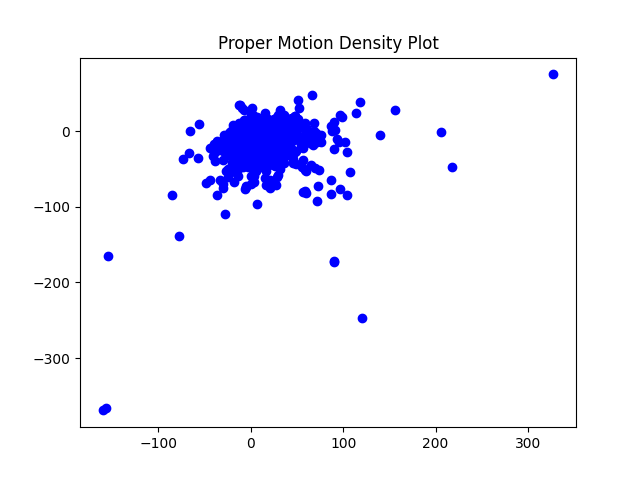

Selected region:
x: -6.66 to 14.61
y: -13.25 to -0.60
Selected region:
x: -9.02 to 12.25
y: -11.72 to 0.93
Selected region:
x: -9.02 to 12.25
y: -14.42 to 0.93
Selected region:
x: -9.02 to 14.90
y: -14.42 to 0.93
Selected region:
x: -9.02 to 14.90
y: -15.22 to 0.93


In [30]:
from matplotlib.widgets import EllipseSelector

g = pd.read_csv('Data/merged.csv', index_col=False)

pmra = g['pmra']
pmdec = g['pmdec']

# Define a function to be called when an ellipse is selected
def onselect(eclick, erelease):
    print("Selected region:")
    print(f"x: {eclick.xdata:.2f} to {erelease.xdata:.2f}")
    print(f"y: {eclick.ydata:.2f} to {erelease.ydata:.2f}")

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(pmra, pmdec, c='blue')
plt.title('Proper Motion Density Plot')

# Create an EllipseSelector instance
selector = EllipseSelector(ax, onselect, interactive=True)

plt.show()

In [31]:
# Specify the condition to remove rows
condition = ((pmdec > -15) & (pmdec < 1)) & ((pmra > -9) & (pmra < 14))

# Apply the condition to filter rows
df = g.loc[condition]

# Save the DataFrame back to the CSV file
df.to_csv('Data/selected_NGC2264.csv', index=False)

r = pd.read_csv('Data/selected_NGC2264.csv', index_col=False)

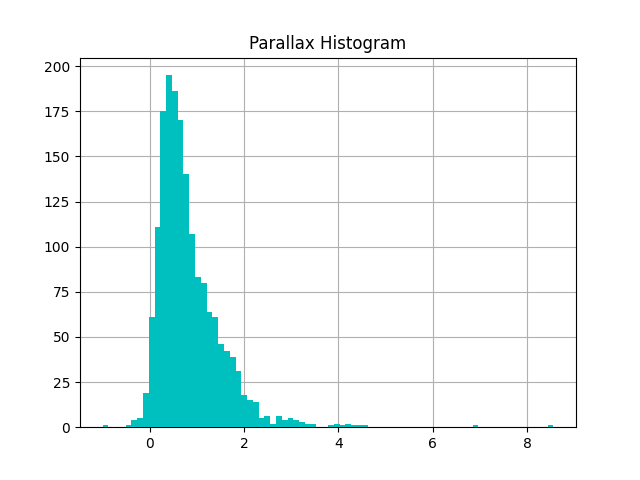

Selected region: x_min=-0.014862456432536836, x_max=1.3304616992477514
Selected region: x_min=0.02460277989129045, x_max=1.3606913006355583


In [32]:
from matplotlib.widgets import SpanSelector

# Define a function to be called when a box is selected
def onselect(xmin, xmax):
    # Print the selected region
    print(f'Selected region: x_min={xmin}, x_max={xmax}')
    return xmin, xmax
p = r['parallax']

# Create a scatter plot
fig, ax = plt.subplots()
plt.hist(p, color='c',bins='auto',zorder=3)
plt.grid(zorder=0)
plt.title('Parallax Histogram')

# Create a SpanSelector
selector = SpanSelector(ax, onselect, 'horizontal', useblit=True)

plt.show()

In [23]:
print(np.mean(p))

0.8113675089607304


In [33]:
condition = ((p > 0.02460277989129045) & (p < 1.3606913006355583))
# Apply the condition to filter rows
df = r.loc[condition]

# Save the DataFrame back to the CSV file
df.to_csv('Data/parallax_selected_NGC2264.csv', index=False)